In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

In [3]:
ls '../input/chest-xray-pneumonia/chest_xray/chest_xray/'  # bu bizimn path'imiz

test/  train/  val/


# Make DataFrame

In [7]:
import os
import pandas as pd

# Ana klasör
base_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'

# Klasörleri ve etiketlerini tanımla
folders = ['train', 'test', 'val']
data = []

# Her klasörü gez ve dosyaları oku
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for label in ['NORMAL', 'PNEUMONIA']:
        label_folder = os.path.join(folder_path, label)
        for file_name in os.listdir(label_folder):
            if file_name.endswith('.jpeg') or file_name.endswith('.png') or file_name.endswith('.jpg'):
                file_path = os.path.join(label_folder, file_name)
                data.append([file_path, label.lower()])

# DataFrame oluştur
df = pd.DataFrame(data, columns=['file_path', 'label'])
df = df.sample(frac=1).reset_index(drop=True)
# İlk birkaç satırı göster
df.head(4)

,file_path,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,pneumonia
1,../input/chest-xray-pneumonia/chest_xray/chest...,normal
2,../input/chest-xray-pneumonia/chest_xray/chest...,pneumonia
3,../input/chest-xray-pneumonia/chest_xray/chest...,normal


In [8]:
df.shape

(5856, 2)

In [9]:
df['label'].unique()
#df['label']=df['label'].map({'normal':0,'pneumonia':1})

array(['pneumonia', 'normal'], dtype=object)

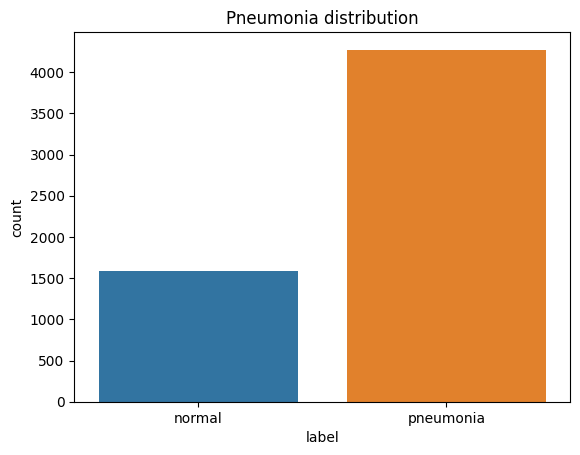

In [9]:
import seaborn as sns
sns.countplot(data=df, x='label')
plt.title('Pneumonia distribution')
plt.show()

Görsel boyutları: 1488x1136
Kanal sayısı: 3


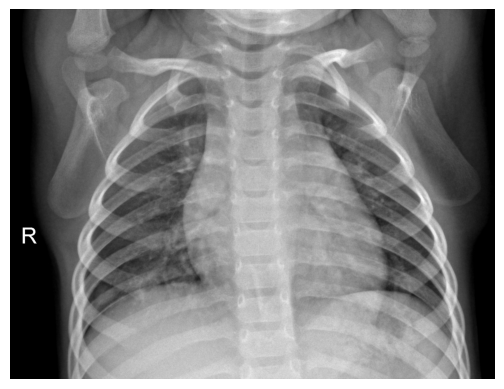

In [8]:
import cv2
import matplotlib.pyplot as plt

# Bir görsel seç (örnek olarak ilk satırdaki görseli alalım)
img_path = df.iloc[0]['file_path']
img = cv2.imread(img_path)

# Görüntü boyutlarını al (yükseklik, genişlik, kanal sayısı)
height, width, d = img.shape

print(f"Görsel boyutları: {width}x{height}")
print(f'Kanal sayısı: {d}')

# OpenCV, BGR formatında okur, RGB formatına dönüştür
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Görseli göster
plt.imshow(img_rgb)
plt.axis('off')  # Eksenleri kapat
plt.show()

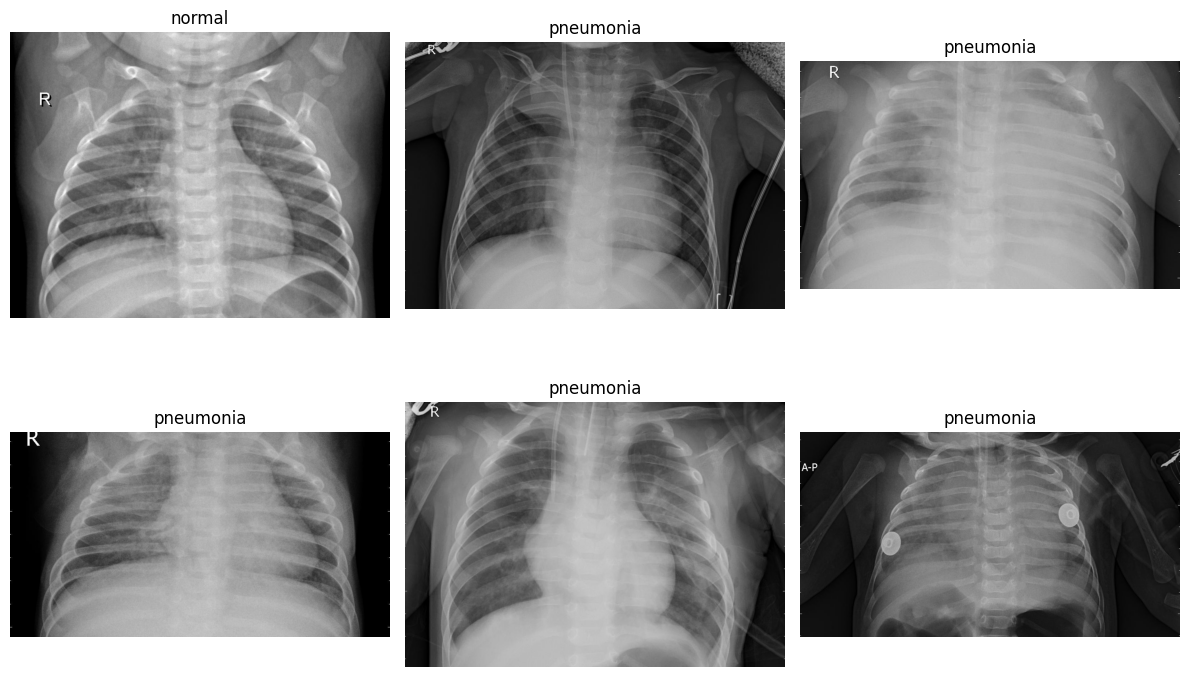

In [15]:
import matplotlib.pyplot as plt
import cv2

# 2x3'lük subplot ayarları
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Her bir görseli sırayla subplotlara yerleştirin
for ax, (_, row) in zip(axes.flatten(), df.sample(6).iterrows()):
    # Resmi yükle
    img = cv2.imread(row['file_path'])
    
    # OpenCV resmi RGB formatına dönüştür
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resmi subplot üzerinde göster
    ax.imshow(img_rgb)
    ax.set_title(row['label'])
    ax.axis('off')

# Subplotlar arası boşlukları ayarla
plt.tight_layout()
plt.show()


In [10]:
df['label'].dtype  # inte çevirdik .

dtype('O')

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Eğitim ve test setini ayır
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Veri artırma için ImageDataGenerator oluşturun
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Eğitim ve test verilerini oluşturun
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(150, 150),  # Boyutları ayarlayın
    batch_size=32,
    class_mode='binary'  # İki sınıf için
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 4684 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # İki sınıf için
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Erken durdurma için callback tanımlayın
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Modeli eğitin
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725201299.853029      82 service.cc:145] XLA service 0x7b333c005170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725201299.853096      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/146 ━━━━━━━━━━━━━━━━━━━━ 27:44 11s/step - accuracy: 0.7188 - loss: 0.6714

I0000 00:00:1725201304.214995      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 124s 778ms/step - accuracy: 0.7471 - loss: 0.5536 - val_accuracy: 0.8602 - val_loss: 0.3638
Epoch 2/20
  1/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6875 - loss: 0.4939

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.4939 - val_accuracy: 0.8500 - val_loss: 0.3419
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 70s 461ms/step - accuracy: 0.8447 - loss: 0.3649 - val_accuracy: 0.8446 - val_loss: 0.3502
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2605 - val_accuracy: 0.9000 - val_loss: 0.2175
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 70s 458ms/step - accuracy: 0.8708 - loss: 0.2964 - val_accuracy: 0.8958 - val_loss: 0.2644
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2840 - val_accuracy: 1.0000 - val_loss: 0.1708
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 70s 461ms/step - accuracy: 0.8774 - loss: 0.2749 - val_accuracy: 0.8724 - val_loss: 0.2881
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.4329 - val_accuracy: 0.9500 - val_loss: 0.2471
Epoch 9/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 72s 474ms/step - accuracy: 0.8781 - loss: 0.2748 - val_accuracy: 0

In [16]:
# Test seti üzerinde model değerlendirmesi
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - accuracy: 0.9418 - loss: 0.1622
Test accuracy: 0.935153603553772


In [26]:
model.save('pneumonia.h5')

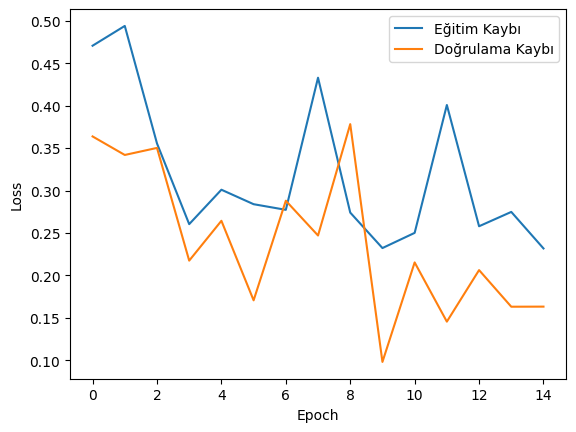

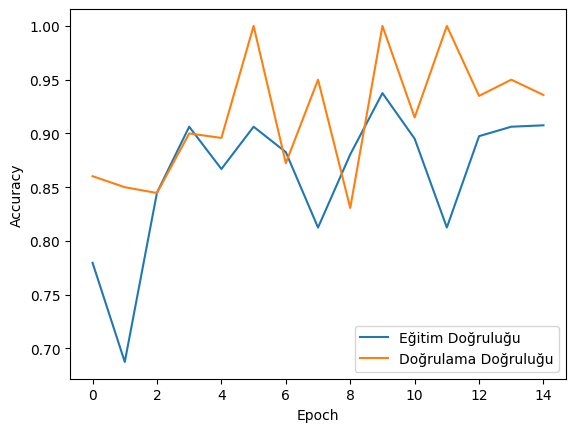

In [17]:
# Eğitim ve Doğrulama Kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim ve Doğrulama Doğruluğu
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# VGG16

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim ve doğrulama için veri artırma ve normalizasyon
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Eğitim verilerinden doğrulama verilerini ayırır
)

# Eğitim verilerini oluşturma
train_gen = datagen.flow_from_directory(
    base_dir + 'train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Doğrulama verilerini oluşturma
val_gen = datagen.flow_from_directory(
    base_dir + 'train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Test verilerini oluşturma (Genellikle sadece normalizasyon yapılır)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    base_dir + 'test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [57]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# VGG16 modelini yükleme ve son katmanlarını çıkarma
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Yeni katmanlar ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary sınıflama için çıkış katmanı

# Yeni model oluşturma
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Temel modelin ağırlıklarını dondurma
for layer in base_model.layers:
    layer.trainable = False

# Modeli derleme
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model_vgg16.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 577ms/step - accuracy: 0.7815 - loss: 0.4520 - val_accuracy: 0.8840 - val_loss: 0.2896
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 486ms/step - accuracy: 0.8857 - loss: 0.2628 - val_accuracy: 0.8830 - val_loss: 0.2783
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 481ms/step - accuracy: 0.8993 - loss: 0.2451 - val_accuracy: 0.9195 - val_loss: 0.1989
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 483ms/step - accuracy: 0.9067 - loss: 0.2151 - val_accuracy: 0.9041 - val_loss: 0.2078
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 485ms/step - accuracy: 0.9106 - loss: 0.2032 - val_accuracy: 0.9060 - val_loss: 0.2101
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 487ms/step - accuracy: 0.9151 - loss: 0.2076 - val_accuracy: 0.9348 - val_loss: 0.1788
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 486ms/step - accuracy: 0.9300 - loss: 0.1844 - val_accuracy: 0.9223 - val_loss: 0.1982
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 481ms/step - accuracy: 0.9260 - loss: 0

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step


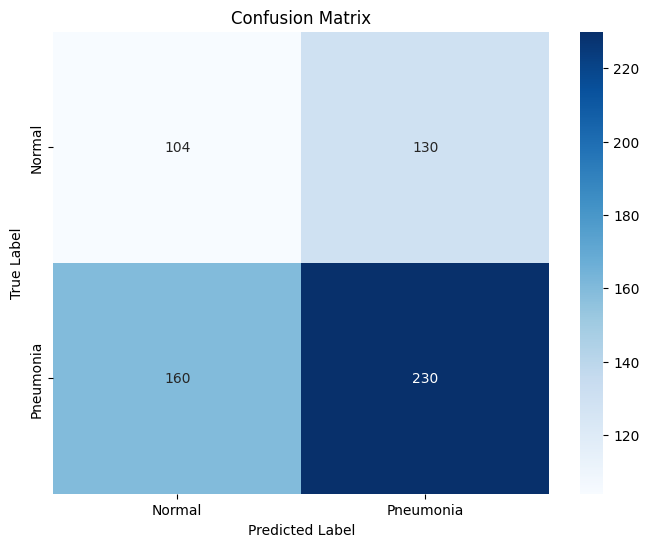

Classification Report:
              precision    recall  f1-score   support

      Normal       0.39      0.44      0.42       234
   Pneumonia       0.64      0.59      0.61       390

    accuracy                           0.54       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.54      0.54       624



In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Test verilerinde tahmin yapma
test_gen.reset()
y_pred = model_vgg16.predict(test_gen)
y_pred = (y_pred > 0.5).astype(int)  # Sigmoid çıkışları ikili sınıflara dönüştür

# Gerçek etiketleri elde etme
y_true = test_gen.classes

# Karışıklık matrisini ve sınıflandırma raporunu hesaplama
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma raporunu hesaplama
report = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'])
print("Classification Report:")
print(report)


In [59]:
model_vgg16.save('zatire_vg.h5')

In [60]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# MobileNetV2 modelini yükleme ve son katmanlarını çıkarma
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Yeni katmanlar ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary sınıflama için çıkış katmanı

# Yeni model oluşturma
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Temel modelin ağırlıklarını dondurma
for layer in base_model.layers:
    layer.trainable = False

# Modeli derleme
model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model_mobilenet.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 552ms/step - accuracy: 0.8038 - loss: 0.6130 - val_accuracy: 0.9022 - val_loss: 0.2234
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 483ms/step - accuracy: 0.8991 - loss: 0.2376 - val_accuracy: 0.9281 - val_loss: 0.1867
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 483ms/step - accuracy: 0.9072 - loss: 0.2093 - val_accuracy: 0.9233 - val_loss: 0.1735
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 476ms/step - accuracy: 0.9101 - loss: 0.2117 - val_accuracy: 0.9223 - val_loss: 0.1811
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 479ms/step - accuracy: 0.9253 - loss: 0.1743 - val_accuracy: 0.9175 - val_loss: 0.1921
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 476ms/step - accuracy: 0.9206 - loss: 0.1963 - val_accuracy: 0.9300 - val_loss: 0.1561
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 480ms/step - accuracy: 0.9354 - loss: 0.1591 - val_accuracy: 0.9281 - val_loss: 0.1717
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step


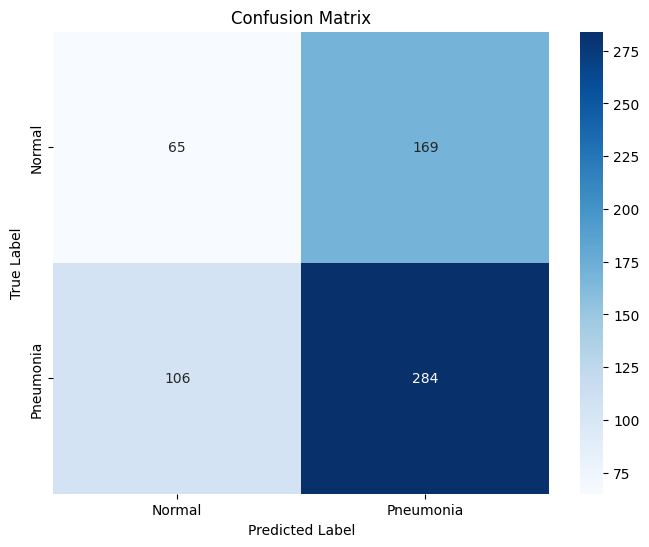

Classification Report:
              precision    recall  f1-score   support

      Normal       0.38      0.28      0.32       234
   Pneumonia       0.63      0.73      0.67       390

    accuracy                           0.56       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.56      0.54       624



In [61]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test verilerini hazırlama (eğitim sırasında model zaten normalizasyon uygulamıştık)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/chest_xray/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Tahminleri yapma
test_gen.reset()  # Test verilerini sıfırlama
y_pred = model_mobilenet.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Binary sınıflandırma

# Gerçek etiketleri elde etme
y_true = test_gen.classes

# Karışıklık matrisini ve sınıflandırma raporunu hesaplama
cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia'])

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma raporunu yazdırma
print("Classification Report:")
print(report)


### Burada classification raporu istediğmi kadar yüksek olmadığından streanlit ile app yapamıyacağım